##### Setup

In [1]:
import sys
import os

# Add the parent directory to the Python path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
sys.path.append(parent_dir)

# Change the current working directory to 'src'
src_dir = os.path.join(parent_dir, 'src')
os.chdir(src_dir)

import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from io import BytesIO
import pandas  as pd
import numpy as np
import re

from concurrent.futures import ThreadPoolExecutor
from data.preprocessing import *

from sklearn.manifold import TSNE
from umap import UMAP

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import tensorflow as tf
from joblib import Parallel, delayed

from sklearn.model_selection import ParameterGrid
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from sklearn.mixture import GaussianMixture
import warnings

warnings.filterwarnings("ignore", message="...", category=FutureWarning)
warnings.filterwarnings("ignore", message="...", category=UserWarning)

seed = 0


### Data Prep
- Adding reprocessing column due to added color mean padding
- I could test removing padding overall, may help overall process

Loaded from pickle file
view processing example-


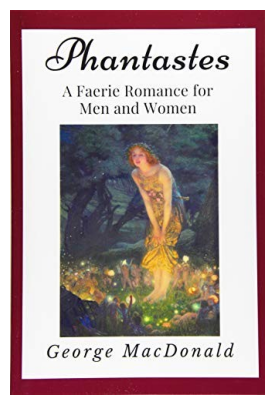

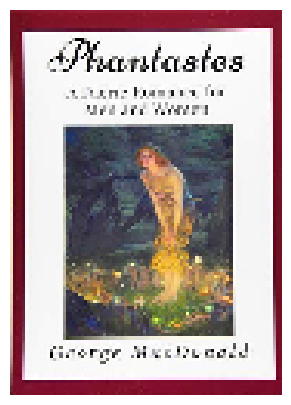

df shape post unknown date drop: (6060, 15) 

See decade distribution:



,work_id,edition_id,cover_url,title,authors,description,subjects,publish_date,genre,unprocessed_img,processed_img,reprocessed_img,reprocessed_img_shape,publish_yr,publish_decade
0,OL15450W,OL47243795M,https://covers.openlibrary.org/b/id/13687428-L...,Phantastes,George MacDonald,One of George MacDonald's most important works...,"Fairy tales, Scottish Fantasy fiction, Fiction...","Nov 05, 2019",Fantasy,"[[[126, 25, 41], [125, 24, 40], [124, 21, 38],...","[0.4941, 0.098, 0.1608, 0.4863, 0.08234, 0.149...","[0.49411765, 0.09803922, 0.16078432, 0.4881793...","(33000,)",2019,2010s
1,OL27495W,OL49943983M,https://covers.openlibrary.org/b/id/14545200-L...,The Silmarillion,J.R.R. Tolkien,A number-one New York Times bestseller when it...,"Fantasy fiction, Short stories, Middle Earth (...",23 gennaio 2013,Fantasy,"[[[0, 8, 11], [0, 8, 11], [0, 8, 11], [0, 8, 1...","[0.0, 0.03137, 0.04315, 0.0, 0.03137, 0.04315,...","[0.0, 0.03137255, 0.043137256, 0.0, 0.03137255...","(33000,)",2013,2010s
31,OL15437W,OL9785045M,https://covers.openlibrary.org/b/id/14363575-L...,Lilith,George MacDonald,"Lilith, written by the father of fantasy liter...","Fiction, romance, fantasy, Fiction, general, N...",1973-09,Fantasy,"[[[8, 10, 9], [8, 10, 9], [11, 11, 11], [19, 1...","[0.03137, 0.0392, 0.0353, 0.04315, 0.04315, 0....","[0.03137255, 0.039215688, 0.03529412, 0.082521...","(33000,)",1973,1970s
32,OL71124W,OL33336356M,https://covers.openlibrary.org/b/id/11959707-L...,The Last Battle,C.S. Lewis,"For the first time, an edition of Lewis's clas...","Juvenile Fiction, Science Fiction & Fantasy, F...",1986,Fantasy,"[[[138, 130, 117], [139, 131, 118], [140, 132,...","[0.541, 0.51, 0.4587, 0.549, 0.5176, 0.4666, 0...","[0.5411765, 0.50980395, 0.45882353, 0.554493, ...","(33000,)",1986,1980s
62,OL1449046W,OL43251544M,https://covers.openlibrary.org/b/id/13135704-L...,The Story of Doctor Dolittle,Hugh Lofting,There are some of us now reaching middle age w...,"Animals, Classic Literature, Children's storie...",2018,Fantasy,"[[[27, 131, 44], [23, 127, 42], [21, 120, 40],...","[0.1059, 0.5137, 0.1726, 0.08234, 0.4707, 0.15...","[0.105882354, 0.5137255, 0.17254902, 0.1810140...","(33000,)",2018,2010s


In [2]:
covers_df_full = prep_data(filename='data/hist/data')

covers_df = covers_df_full.drop_duplicates(subset='title')
covers_df.head()

## UMAP
- I could attempt dimensionality redux at an individual image level ahead of the overall umap
- could use validation set as i grid search to avoid overfitting

In [3]:
# New best ARI: 0.01011893287093633 with params: {'clustering_algo': <class 'sklearn.cluster._dbscan.DBSCAN'>, 'clustering_params': {'eps': 0.1, 'min_samples': 5}, 'metric': 'cosine', 'min_dist': 0.01, 'n_components': 2, 'n_neighbors': 30}
# 
# {'clustering_algo': <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>, 'clustering_params': {'n_components': 11, 'covariance_type': 'full', 'random_state': 0}, 'metric': 'cosine', 'min_dist': 0.25, 'n_components': 2, 'n_neighbors': 10}

In [4]:
def find_best_umap_params(img_arr, covers_df, param_grid, random_state=0):    
    best_score = -1
    best_params = None
    best_umap = None
    best_model = None
    best_labels = None

    for params in ParameterGrid(param_grid):
        try:
            try:
                clustering_algo = params['clustering_algo']
                clustering_params = params['clustering_params']
                clustering_model = clustering_algo(**clustering_params)
            except:
                continue
            print(f"Trying params: {params}")
            umap_model = UMAP(
                n_components=params.get('n_components', 2),
                n_neighbors=params.get('n_neighbors', 15),
                min_dist=params.get('min_dist', 0.1),
                metric=params.get('metric', 'euclidean'),
                # random_state=random_state
            )
            umap_embeddings = umap_model.fit_transform(img_arr)
            
            clustering_labels = clustering_model.fit_predict(umap_embeddings)
            
            # Use ARI to evaluate the clustering quality
            score = adjusted_rand_score(covers_df['genre'].astype('category').cat.codes, clustering_labels)
            
            if score > best_score:
                print(f"\tNew best ARI: {score} with params: {params}")
                best_score = score
                best_params = params
                best_umap = umap_embeddings
                best_model = clustering_model
                best_labels = clustering_labels
        except Exception as e:
            print(f"\tError with params: {params}, Exception: {e}")
            continue
        print()    
    return best_params, best_score, best_umap, best_model, best_labels

def umap(covers_df, filename):
    try:
        covers_df = pd.read_pickle(f'data/{filename}_umap.pkl')
    except:
        print('No exsiting modeled data\n\nApplying grid search for UMAP & clustering params\n\n')
        
        param_grid = {
        'n_components': [2, 3], #increased range
        'n_neighbors': [10, 30, 50],
        'min_dist': [0.01, 0.25],
        'metric': ['cosine'],
        'clustering_algo': [GaussianMixture], # AgglomerativeClustering, DBSCAN, KMeans,
        'clustering_params': [
            {'n_clusters': len(covers_df['genre'].unique().tolist())},
            # {'eps': 0.1, 'min_samples': 5},
            # {'eps': 0.9, 'min_samples': 5},
            # {'eps': 0.1, 'min_samples': 10},
            # {'eps': 0.9, 'min_samples': 10},
            # {'n_clusters': len(covers_df['genre'].unique().tolist()), 'random_state': seed},
            {'n_components': len(covers_df['genre'].unique().tolist()), 'covariance_type': 'full', 'random_state': seed}
            ]
        }
        
        flattened_downsampled_images = np.stack(covers_df['reprocessed_img'].values)
        print(flattened_downsampled_images.shape)
        best_params, best_score, best_umap, best_model, best_labels = find_best_umap_params(flattened_downsampled_images, covers_df, param_grid, random_state=seed)
        print(f"Best Model: {best_model}\nBest Params: {best_params}\nBest Score: {best_score}\nApplying best params now")
        
        covers_df['umap_x'] = best_umap[:, 0]
        covers_df['umap_y'] = best_umap[:, 1]
        try:
            covers_df['umap_z'] = best_umap[:, 2]
        except:
            pass
        
        covers_df['cluster_pred'] = best_labels
        
        covers_df.to_pickle(f'data/{filename}_umap.pkl')
    return covers_df, best_params

# covers_df, best_params = umap(covers_df, 'cluster_nmi_fitting')

# flattened_downsampled_images = np.stack(covers_df['reprocessed_img'])

# labels = covers_df['cluster_pred']

# genre_list = covers_df['genre'].unique().tolist()
# n_clusters = len(genre_list)

# Apply the best clustering algorithm found
# best_clustering_algo = best_params['clustering_algo']
# best_clustering_params = best_params['clustering_params']
# clustering_labels = best_clustering_algo(**best_clustering_params).fit_predict(covers_df[['umap_x', 'umap_y']])
# covers_df['best_clustering_labels'] = clustering_labels

In [5]:
params = {'clustering_algo': GaussianMixture, 'clustering_params': {'n_components': 11, 'covariance_type': 'full', 'random_state': 0}, 'metric': 'cosine', 'min_dist': 0.25, 'n_components': 2, 'n_neighbors': 10}

clustering_algo = params['clustering_algo']
clustering_params = params['clustering_params']
clustering_model = clustering_algo(**clustering_params)

print(f"Trying params: {params}")
umap_model = UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    metric='cosine',
    random_state=seed
)
flattened_downsampled_images = np.stack(covers_df['reprocessed_img'].values)
umap_embeddings = umap_model.fit_transform(flattened_downsampled_images)

clustering_labels = clustering_model.fit_predict(umap_embeddings)

# Use ARI to evaluate the clustering quality
score = adjusted_rand_score(covers_df['genre'].astype('category').cat.codes, clustering_labels)
score

Trying params: {'clustering_algo': <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>, 'clustering_params': {'n_components': 11, 'covariance_type': 'full', 'random_state': 0}, 'metric': 'cosine', 'min_dist': 0.25, 'n_components': 2, 'n_neighbors': 10}


0.009109047155076714

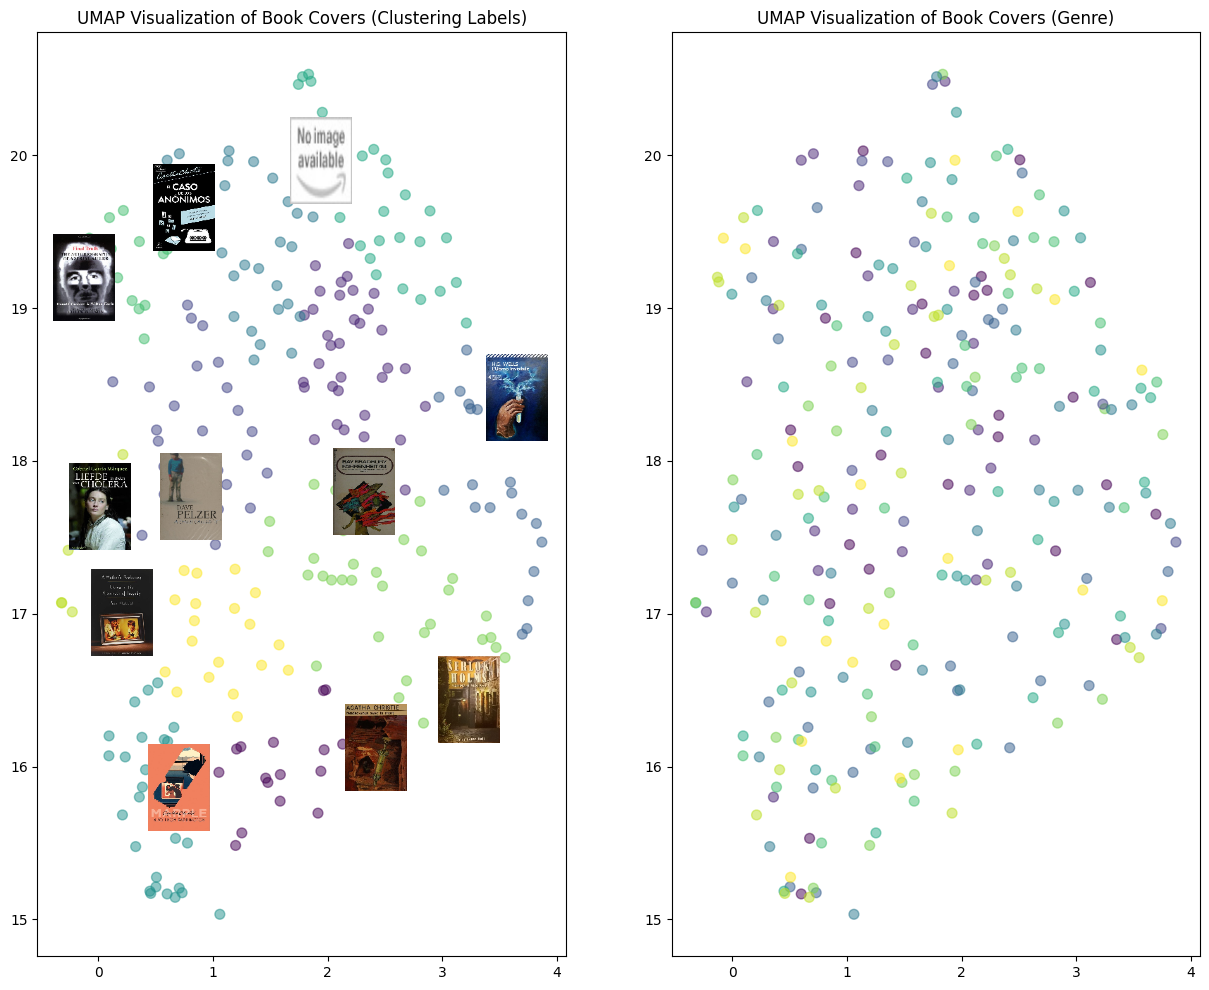

In [6]:
plt.figure(figsize=(15, 12))

# Plot colored by clustering labels
plt.subplot(1, 2, 1)
scatter = plt.scatter(umap_embeddings[:,0], umap_embeddings[:,1], alpha=0.5, c=clustering_labels, cmap='viridis', s=50)
plt.title('UMAP Visualization of Book Covers (Clustering Labels)')

covers_df.reset_index(drop=True, inplace=True)
random_indices = []
for cluster_label in np.unique(clustering_labels):
    cluster_indices = np.where(clustering_labels == cluster_label)[0]
    random_index = np.random.choice(cluster_indices, size=1, replace=False)
    random_indices.append(random_index[0])
random_indices = np.array(random_indices)

for i in random_indices:
    img = flattened_downsampled_images[i]
    img = img.reshape(125, 88, 3).astype(np.float32)
    
    x0, y0 = umap_embeddings[i,0], umap_embeddings[i,1]
    imgbox = OffsetImage(img, zoom=0.5)
    ab = AnnotationBbox(imgbox, (x0, y0), frameon=False)
    plt.gca().add_artist(ab)

# Plot colored by genre
plt.subplot(1, 2, 2)
plt.scatter(umap_embeddings[:,0], umap_embeddings[:,1], alpha=0.5, c=covers_df['genre'].astype('category').cat.codes, cmap='viridis', s=50)
plt.title('UMAP Visualization of Book Covers (Genre)')

plt.show()

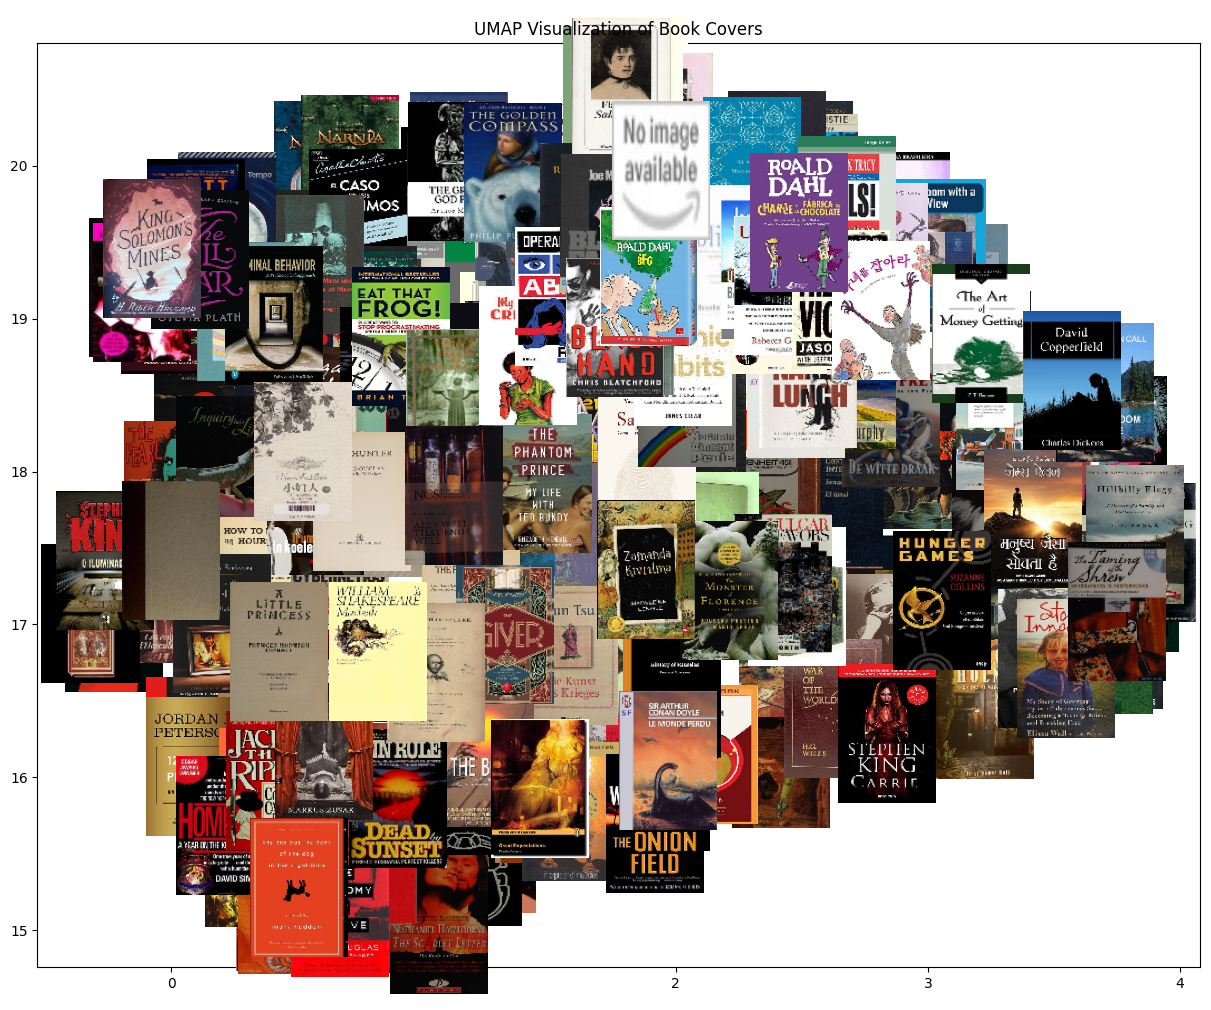

In [7]:
plt.figure(figsize=(15, 12))
scatter = plt.scatter(umap_embeddings[:,0], umap_embeddings[:,1], alpha=0.5, c=clustering_labels, cmap='viridis', s=50)
plt.title('UMAP Visualization of Book Covers')

covers_df.reset_index(drop=True, inplace=True)

for i in range(len(umap_embeddings)):
    img = flattened_downsampled_images[i]
    img = img.reshape(125, 88, 3).astype(np.float32)
    
    x0, y0 = umap_embeddings[i,0], umap_embeddings[i,1]
    imgbox = OffsetImage(img, zoom=0.8)
    ab = AnnotationBbox(imgbox, (x0, y0), frameon=False)
    plt.gca().add_artist(ab)

plt.show()

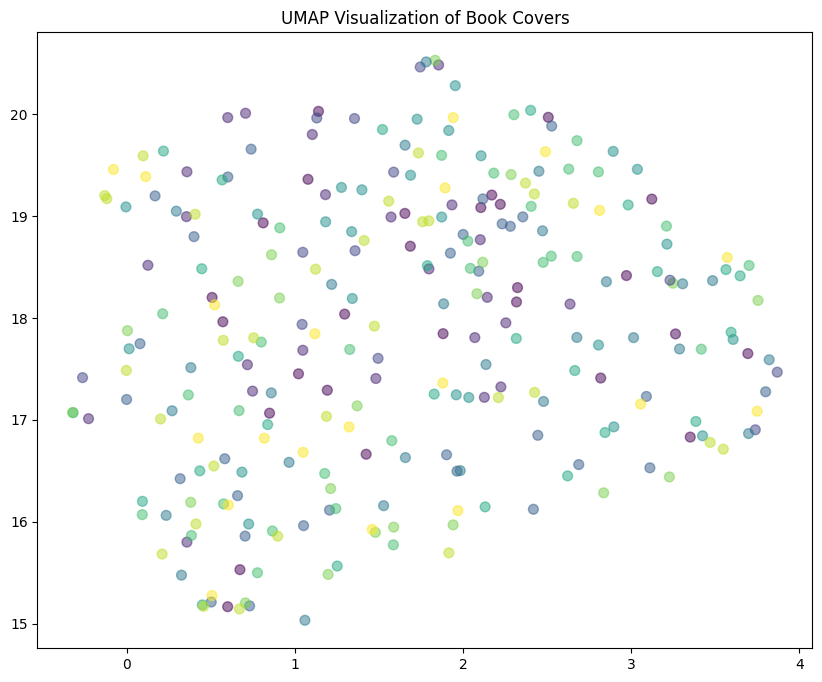

In [8]:
plt.figure(figsize=(10, 8))
plt.scatter(umap_embeddings[:,0], umap_embeddings[:,1], alpha=0.5, c=covers_df['genre'].astype('category').cat.codes, cmap='viridis', s=50)
plt.title('UMAP Visualization of Book Covers')
plt.show()